### Efficientnet

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers,losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Flatten, Dropout, GlobalAveragePooling2D,Activation, Input, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Add, Subtract, Concatenate
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB0


import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [3]:
#help('modules')

In [178]:
# def build_model(num_classes, drop_rates, input_dim, training, pooling='max'):
#     inputs=Input(shape=input_dim)
#     base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
#     base_model.trainable=True
#     x = base_model.output
#     #classification head
#     x = Dropout(drop_rates[0], name='top_dropout_1')(x,training=training)
#     if pooling == 'avg':
#         x = GlobalAveragePooling2D(name='avg_pool')(x)
#     elif pooling == 'max':
#         x = GlobalMaxPooling2D(name='max_pool')(x)
#     x = Dropout(drop_rates[1], name='top_dropout_2')(x,training=training)
#     x = Dense(32,activation='relu', name='dense_32')(x)
#     x = Dense(num_classes,activation='softmax', name='dense_out')(x)
#     model =Model(inputs=inputs,outputs=x)
#     return model

In [2]:
def build_model(num_classes, drop_rates, input_dim, training, pooling='max'):
    inputs=Input(shape=input_dim)
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable=True
    x = base_model.output
    x = Dropout(drop_rates[0], name='top_dropout_1')(x,training=training)
    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='max_pool')(x)   
    x = Dropout(drop_rates[0], name='top_dropout_2')(x,training=training)
    x = Dense(512,activation='relu', name='dense_512')(x)
    x = Dropout(drop_rates[1], name='top_dropout_3')(x,training=training)
    #classification head 
    x = Dense(num_classes,activation='softmax', name='dense_out')(x)
    
    model =Model(inputs=inputs,outputs=x)
    return model

In [5]:
#drop_rates= np.r_[0.1:1.2:0.1]
drop_rates = [0.4,0.1]
training=True
num_classes=2
input_dims=(224,224,3)
drop_rates

[0.4, 0.1]

In [4]:
learning_rate = 0.01

lr_decay = 1e-6

lr_drop = 20

def lr_scheduler(epoch):
    return learning_rate * (0.25 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [25]:
model = build_model(num_classes=num_classes,drop_rates=drop_rates,input_dim=input_dims,training=True,pooling='avg')

In [69]:
# learning_rate = 0.0001
# adam = optimizers.Adam(lr=learning_rate)
# model.compile(optimizer=adam,loss=losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [26]:
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,loss=losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [30]:
# model.summary()
#model.output

### Create callback for saving weights

In [9]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "efficientnet2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_feq=2)

In [10]:
early_stop_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=5, verbose=0, restore_best_weights=True
)

### Train the model

**Data**

In [11]:
train_dir=pathlib.Path('../.keras/datasets/isic_2019/train')
val_dir=pathlib.Path('../.keras/datasets/isic_2019/validation')

In [12]:
images_count=len(list(train_dir.glob("*/*.jpg")))+len(list(val_dir.glob("*/*.jpg")))

In [13]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'))

In [27]:
CLASS_NAMES=['Benign','Malignant','Unknown']
BATCH_SIZE = 32
STEPS_PER_EPOCH=images_count/(BATCH_SIZE*2)
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS=3
IMG_SHAPE=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)
validation_steps=images_count/(BATCH_SIZE*2)
initial_epoch=0
EPOCHS = 50

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [16]:
def process_data(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    if(parts[-3]=='test'):
      # The second to last is the class-directory
      label = parts[-2] == CLASS_NAMES
    else:
        label = parts[-2] == CLASS_NAMES[:2]
        
    img_label = tf.dtypes.cast(label,dtype=tf.int16)    
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img_label
   
def prepare_batches(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds     

In [17]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_data, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_data, num_parallel_calls=AUTOTUNE)

In [18]:
# for f in train_ds.take(2):
#     print(f)

In [19]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [0 1]


### Shuffle training data and get batches

In [20]:
train_ds = prepare_batches(train_ds)
val_ds=prepare_batches(val_ds)
#image_batch, label_batch = next(iter(train_ds))

Understanding the data

In [21]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[np.where(label_batch[n])[0][0]])
        plt.axis('off')

In [22]:
#image_batch.shape

In [23]:
#show_batch(image_batch.numpy(), label_batch.numpy())

In [28]:
history = model.fit(
    train_ds,
    initial_epoch=initial_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=validation_steps,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr,early_stop_callback,cp_callback]
)

Epoch 1/50
301/300 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.7713
Epoch 00001: saving model to efficientnet2/cp-0001.ckpt
301/300 [==============================] - 72s 238ms/step - loss: 0.6215 - accuracy: 0.7713 - val_loss: 0.6357 - val_accuracy: 0.7255 - lr: 0.0100
Epoch 2/50
301/300 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.8292
Epoch 00002: saving model to efficientnet2/cp-0002.ckpt
301/300 [==============================] - 73s 242ms/step - loss: 0.5893 - accuracy: 0.8292 - val_loss: 0.5857 - val_accuracy: 0.8361 - lr: 0.0100
Epoch 3/50
301/300 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.8516
Epoch 00003: saving model to efficientnet2/cp-0003.ckpt
301/300 [==============================] - 73s 243ms/step - loss: 0.5779 - accuracy: 0.8516 - val_loss: 0.5824 - val_accuracy: 0.8402 - lr: 0.0100
Epoch 4/50
301/300 [==============================] - ETA: 0s - loss: 0.5734 - accuracy: 0.8599
Epoch 0

In [139]:
latest = tf.train.latest_checkpoint(checkpoint_dir) #choose the latest check point
#latest = "dropnet/cp-0139.ckpt"

# # Load the previously saved weights
model.load_weights(latest)

### Visualize Learning curve

In [31]:
fname="efficientnet2_acc.csv"
# f=open(fname,"w")
# f.write('acc,val_acc,loss,val_loss\n')
# f.close()

In [32]:
a=np.array([history.history['accuracy'],history.history['val_accuracy'],history.history['loss'],history.history['val_loss']]).T

In [33]:
#receives a list of strings
def write_csv(filename,recs):
    recs=recs.astype('str')
    print(recs.shape)
    f=open(filename,"a+")
    for rec in recs:
        f.write("%s\n" % ','.join(list(rec)))
    f.close()    

In [34]:
write_csv(fname,a)

(31, 4)


In [35]:
def read_csv(filename):
    f = open(filename,'r')
    recs = []
    lines = f.readlines()
    for line in lines:
        #print(line.strip('\n').split(','))
        recs.append(line.strip('\n').split(','))
    print(len(recs))
    return recs

In [36]:
lr_curve=np.array(read_csv(fname))

32


In [87]:
lr_curve.shape

(39, 4)

In [37]:
acc = lr_curve[1:,0].astype(float)
val_acc = lr_curve[1:,1].astype(float)
loss = lr_curve[1:,2].astype(float)
val_loss = lr_curve[1:,3].astype(float)

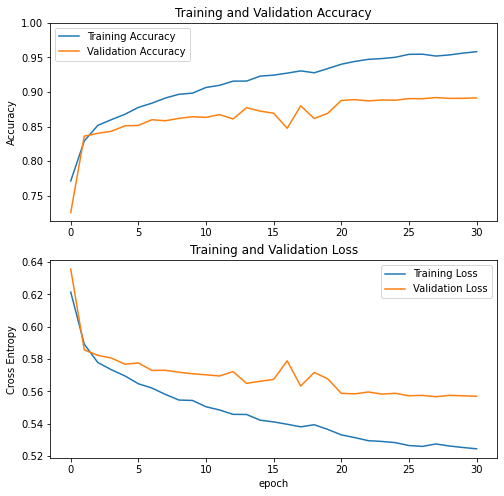

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model

In [31]:
# Save the entire model as a SavedModel.
# !mkdir -p dropnet_model
# model.save('dropnet_model/my_model')

In [32]:
# my_model directory
# !ls dropnet_model

# Contains an assets folder, saved_model.pb, and variables folder.
# !ls dropnet_model/my_model